In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from zipfile import ZipFile
from sklearn.utils import class_weight

In [2]:
print(os.listdir("plant disease detection dataset"))

data_dir = 'plant disease detection dataset'

['.ipynb_checkpoints', 'diseased', 'healthy']


In [3]:
# Data Augmentation and Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2  # 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 329 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


In [4]:
# Checking class distribution
class_labels = train_generator.class_indices
print("Class labels:", class_labels)
classes = list(train_generator.class_indices.keys())

# Calculating class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights)

Class labels: {'.ipynb_checkpoints': 0, 'diseased': 1, 'healthy': 2}
Class weights: {0: 0.5633561643835616, 1: 4.445945945945946}


In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam  # Corrected this part

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a lower learning rate using the Adam optimizer
from tensorflow.keras.optimizers import SGD

# Compile the model with a lower learning rate using the SGD optimizer
model.compile(optimizer=SGD(learning_rate=0.00001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    class_weight=class_weights  # Added class weights to handle imbalanced data
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 9s/step - accuracy: 0.8836 - loss: 0.3739 - val_accuracy: 0.8125 - val_loss: 0.5771
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.9062 - loss: 0.3923 - val_accuracy: 0.8235 - val_loss: 0.6307
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 97s 9s/step - accuracy: 0.8784 - loss: 0.0690 - val_accuracy: 0.7031 - val_loss: 0.6264
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9375 - loss: 0.2355 - val_accuracy: 0.6471 - val_loss: 0.5756
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 99s 9s/step - accuracy: 0.9106 - loss: 0.0681 - val_accuracy: 0.8906 - val_loss: 0.5416
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.8750 - loss: -0.1069 - val_accuracy: 0.8235 - val_loss: 0.5041
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 9s/step - accuracy: 0.8932 - loss: -0.0572 - val_accuracy: 0.8750 - val_loss: 0.4134
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.9062 - loss: 0.0168 - val_accuracy: 0.94

In [18]:
val_loss, val_accuracy = model.evaluate(validation_generator)
val_accuracy_percent = val_accuracy * 100
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy_percent:.2f}%')


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8898 - loss: -0.2458
Validation Loss: -0.2614101767539978
Validation Accuracy: 88.89%


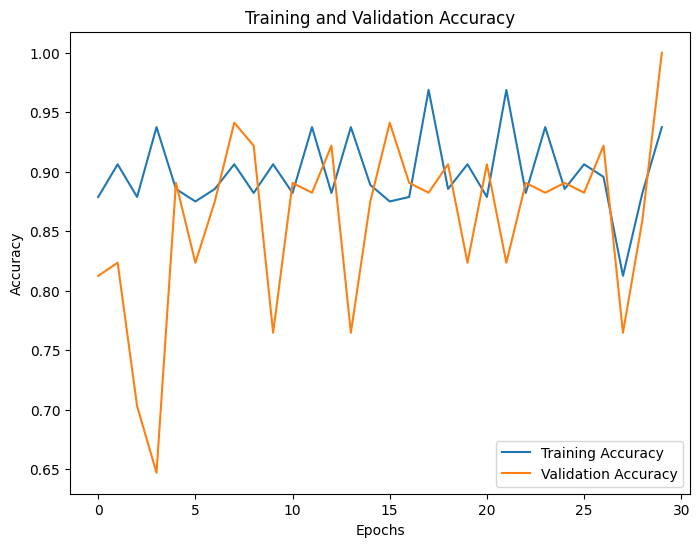

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

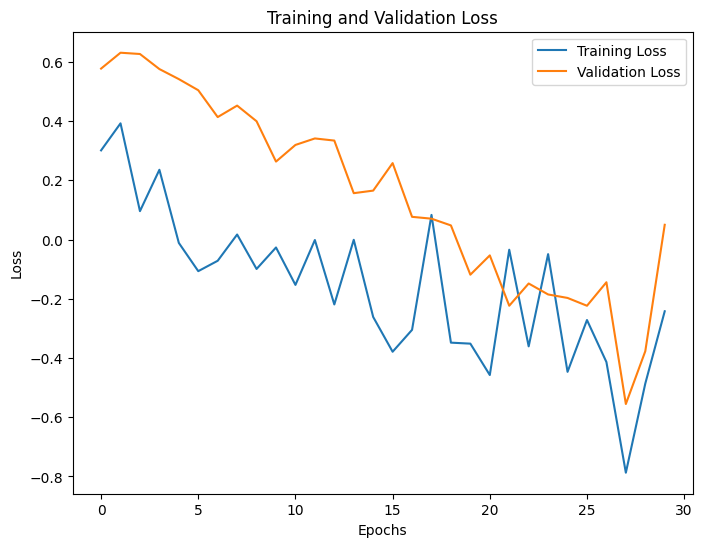

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

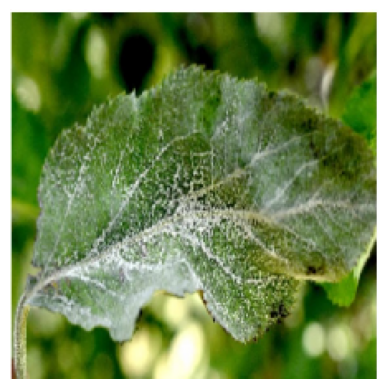

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Prediction: Diseased


In [21]:
from tensorflow.keras.preprocessing import image

def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels)
    img_tensor /= 255.                                      # rescale by 1/255

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

new_image = load_image('apple_img.jpg', show=True)
pred = model.predict(new_image)
print(f'Prediction: {"Healthy" if pred < 0.5 else "Diseased"}')